# Building a Small Language Model from Scratch


<a target="_blank" href="https://colab.research.google.com/github/wecacuee/ECE490-S26-Neural-Networks/blob/master/notebooks/012-example-llm/SmallLLM.ipynb"><strong>OPEN IN COLAB</strong></a>

In this notebook, we will build a small **Large Language Model (LLM)** from scratch using PyTorch. Despite the name "Large" Language Model, we'll train a small version that demonstrates all the core concepts, so that it fits on Google Colab GPU.

## Learning Objectives

By the end of this notebook, you will understand:
1. How language models work (predicting the next token)
3. Training a generative model
4. Generating text and building a chat interface
5. Core concepts of Dataset (training/validation/test), Model, Loss, Training/Optimization, Evaluation, Metrics

## Table of Contents

1. [Setup](#1-setup)
2. [Dataset](#2-dataset)
3. [Model](#3-model)
4. [Loss Function](#4-loss-function)
5. [Training](#5-training)
6. [Evaluation](#6-evaluation)
7. [Chat Interface](#7-chat-interface)

## 1. Setup 
<a id="1-setup"></a>

First, let's import the necessary libraries and set up our computing device. On Google Colab, go to "Runtime" > "Change runtime type" and select "Hardware accelerator" as "T4 GPU".

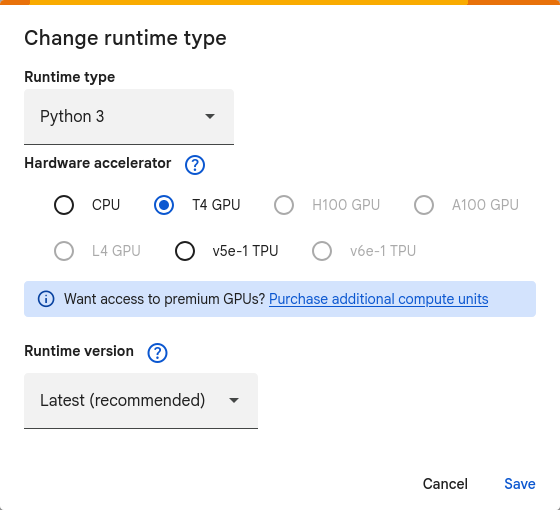

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import time
import math
import urllib.request
import os

# Check for GPU availability
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Using CUDA GPU: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple MPS (Metal Performance Shaders)")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU (training will be slower)")

print(f"PyTorch version: {torch.__version__}")

Using CUDA GPU: NVIDIA GeForce RTX 3090
PyTorch version: 2.9.0+cu128


## 2. Dataset 
<a id="2-dataset"></a>

### 2.1 What is a Language Model?

A language model learns to predict the next token given a sequence of previous tokens:

$$P(x_{t+1} | x_1, x_2, ..., x_t)$$

For example, given "The cat sat on the", a good language model should predict "mat" or "floor" with high probability.

### 2.2 Tokenization

**Tokenization** is the process of converting text into numerical tokens. There are several approaches:

| Method | Example | Vocabulary Size | Pros | Cons |
|--------|---------|-----------------|------|------|
| Character-level | "hello" → [h, e, l, l, o] | ~100 | Small vocab, handles any word | Long sequences |
| Word-level | "hello world" → [hello, world] | ~50,000+ | Semantic meaning | Large vocab, OOV issues |
| Subword (BPE) | "unhappy" → [un, happy] | ~30,000 | Balance of both | More complex |

We'll use **character-level tokenization** for simplicity. This means:
- Each unique character gets a unique integer ID
- The vocabulary is small (around 65 characters for English text)
- The model learns to predict one character at a time

In [2]:
# Download a small Shakespeare dataset (about 1MB of text)
DATA_URL = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
DATA_FILE = "shakespeare.txt"

if not os.path.exists(DATA_FILE):
    print("Downloading Shakespeare dataset...")
    urllib.request.urlretrieve(DATA_URL, DATA_FILE)
    print("Download complete!")

# Load the text
with open(DATA_FILE, 'r', encoding='utf-8') as f:
    text = f.read()

print(f"Dataset size: {len(text):,} characters")
print(f"\nFirst 500 characters:\n{'-'*50}")
print(text[:500])

Dataset size: 1,115,394 characters

First 500 characters:
--------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


### 2.3 Building a Character Tokenizer

Our tokenizer needs two functions:
1. `encode(text)` → converts text string to list of integers
2. `decode(tokens)` → converts list of integers back to text string

In [3]:
class CharacterTokenizer:
    """A simple character-level tokenizer.
    
    This tokenizer maps each unique character to an integer ID.
    """
    
    def __init__(self, text):
        """Build vocabulary from text."""
        # Get all unique characters and sort them
        self.chars = sorted(list(set(text)))
        self.vocab_size = len(self.chars)
        
        # Create mappings: character <-> integer
        self.char_to_id = {ch: i for i, ch in enumerate(self.chars)}
        self.id_to_char = {i: ch for i, ch in enumerate(self.chars)}
    
    def encode(self, text):
        """Convert text string to list of token IDs."""
        return [self.char_to_id[ch] for ch in text]
    
    def decode(self, token_ids):
        """Convert list of token IDs back to text string."""
        return ''.join([self.id_to_char[i] for i in token_ids])

# Create our tokenizer
tokenizer = CharacterTokenizer(text)

print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Characters: {''.join(tokenizer.chars)}")

# Test encode/decode
test_text = "Hello, World!"
encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)

print(f"\nTest: '{test_text}'")
print(f"Encoded: {encoded}")
print(f"Decoded: '{decoded}'")

Vocabulary size: 65
Characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz

Test: 'Hello, World!'
Encoded: [20, 43, 50, 50, 53, 6, 1, 35, 53, 56, 50, 42, 2]
Decoded: 'Hello, World!'


### 2.4 Creating a PyTorch Dataset

For language modeling, we create training examples as follows:
- **Input (x)**: A sequence of `block_size` tokens
- **Target (y)**: The same sequence shifted by one position (next token prediction)

Example with `block_size=8`:
```
Text:   "The quick brown fox"
Input:  [T, h, e,  , q, u, i, c]  (positions 0-7)
Target: [h, e,  , q, u, i, c, k]  (positions 1-8)
```

This way, at each position, the model learns to predict the next character.

In [4]:
class TextDataset(Dataset):
    """PyTorch Dataset for character-level language modeling.
    
    Each sample contains:
    - x: input sequence of length block_size
    - y: target sequence (x shifted by 1 position)
    """
    
    def __init__(self, text, tokenizer, block_size):
        """
        Args:
            text: The text to create dataset from
            tokenizer: Tokenizer to encode the text
            block_size: Length of each training sequence (context window)
        """
        self.block_size = block_size
        
        # Encode entire text into tokens
        self.data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
        
    def __len__(self):
        # Number of possible starting positions
        return len(self.data) - self.block_size
    
    def __getitem__(self, idx):
        # Get a chunk of block_size + 1 tokens
        chunk = self.data[idx : idx + self.block_size + 1]
        
        # Input is first block_size tokens, target is shifted by 1
        x = chunk[:-1]  # First block_size tokens
        y = chunk[1:]   # Last block_size tokens (shifted by 1)
        
        return x, y

# Hyperparameters for the dataset
BLOCK_SIZE = 64  # Context length (how many characters the model sees)
# Full dataset (100%) takes around 30 min, 10% takes around 2-3 minutes.
PERCENTAGE_DATASET_TO_USE = 10 # Use a smaller percentage of dataset

# Split data: 80% train, 10% validation, 10% test
len_text_to_use = int(PERCENTAGE_DATASET_TO_USE * len(text)/100)
train_val_split_idx = int(0.8 * len_text_to_use)
val_test_split_idx = int(0.9 * len_text_to_use)
train_text = text[:train_val_split_idx]
val_text = text[train_val_split_idx:val_test_split_idx]
test_text = text[val_test_split_idx:len_text_to_use]

# Create datasets
train_dataset = TextDataset(train_text, tokenizer, BLOCK_SIZE)
val_dataset = TextDataset(val_text, tokenizer, BLOCK_SIZE)
test_dataset = TextDataset(test_text, tokenizer, BLOCK_SIZE)

print(f"Training samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")

# Look at one sample
x, y = train_dataset[0]
print(f"\nSample input shape: {x.shape}")
print(f"Sample target shape: {y.shape}")
print(f"\nInput:  '{tokenizer.decode(x.tolist())}'")
print(f"Target: '{tokenizer.decode(y.tolist())}'")

Training samples: 89,167
Validation samples: 11,090

Sample input shape: torch.Size([64])
Sample target shape: torch.Size([64])

Input:  'First Citizen:
Before we proceed any further, hear me speak.

Al'
Target: 'irst Citizen:
Before we proceed any further, hear me speak.

All'


In [5]:
# Create DataLoaders for batching
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check batch dimensions
x_batch, y_batch = next(iter(train_loader))
print(f"Batch input shape:  {x_batch.shape}  (batch_size, block_size)")
print(f"Batch target shape: {y_batch.shape}  (batch_size, block_size)")

Batch input shape:  torch.Size([32, 64])  (batch_size, block_size)
Batch target shape: torch.Size([32, 64])  (batch_size, block_size)


## 3. Model 
<a id="3-model"></a>

Too many details that we will learn later in the course. What you will learn is that these are neurons connected in a particular order that forms a Model.

In [6]:
class CausalSelfAttention(nn.Module):
    """Multi-head causal self-attention.
    
    Causal means each position can only attend to previous positions.
    Multi-head means we run multiple attention operations in parallel.
    """
    
    def __init__(self, embed_dim, num_heads, block_size, dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5  # 1/sqrt(d_k)
        
        # Linear projections for Q, K, V (combined into one for efficiency)
        self.qkv_proj = nn.Linear(embed_dim, 3 * embed_dim, bias=False)
        
        # Output projection
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        
        # Dropout for regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.out_dropout = nn.Dropout(dropout)
        
        # Causal mask: prevents attending to future positions
        # Lower triangular matrix of ones
        self.register_buffer(
            "causal_mask",
            torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size)
        )
    
    def forward(self, x):
        B, T, C = x.shape  # Batch, Time (sequence length), Channels (embed_dim)
        
        # Compute Q, K, V projections
        qkv = self.qkv_proj(x)  # (B, T, 3*C)
        q, k, v = qkv.chunk(3, dim=-1)  # Each is (B, T, C)
        
        # Reshape for multi-head attention: (B, T, C) -> (B, num_heads, T, head_dim)
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Compute attention scores: (B, num_heads, T, T)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        
        # Apply causal mask (set future positions to -inf before softmax)
        attn = attn.masked_fill(self.causal_mask[:, :, :T, :T] == 0, float('-inf'))
        
        # Softmax to get attention weights
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_dropout(attn)
        
        # Apply attention to values: (B, num_heads, T, head_dim)
        out = attn @ v
        
        # Reshape back: (B, num_heads, T, head_dim) -> (B, T, C)
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        
        # Final projection
        out = self.out_dropout(self.out_proj(out))
        
        return out

In [7]:
class TransformerBlock(nn.Module):
    """A single Transformer block.
    
    Structure:
        x -> LayerNorm -> Self-Attention -> + x (residual)
          -> LayerNorm -> Feed-Forward -> + x (residual)
    """
    
    def __init__(self, embed_dim, num_heads, block_size, dropout=0.1):
        super().__init__()
        
        # Layer normalizations (pre-norm architecture)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        
        # Self-attention
        self.attention = CausalSelfAttention(embed_dim, num_heads, block_size, dropout)
        
        # Feed-forward network (MLP)
        # Typically expands by 4x, then projects back down
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(),  # Modern activation function
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        # Self-attention with residual connection
        x = x + self.attention(self.ln1(x))
        
        # Feed-forward with residual connection
        x = x + self.mlp(self.ln2(x))
        
        return x

### 3.4 The Complete Language Model

Too many details that we will learn later in the course. 

In [8]:
class SmallLLM(nn.Module):
    """A small GPT-style language model.
    
    Architecture:
        1. Token embedding
        2. Positional embedding  
        3. N transformer blocks
        4. Final layer norm
        5. Output projection to vocabulary
    """
    
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, block_size, dropout=0.1):
        """
        Args:
            vocab_size: Number of tokens in vocabulary
            embed_dim: Dimension of token embeddings
            num_heads: Number of attention heads
            num_layers: Number of transformer blocks
            block_size: Maximum sequence length (context window)
            dropout: Dropout probability
        """
        super().__init__()
        self.block_size = block_size
        
        # Token embedding: vocab_size -> embed_dim
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Positional embedding: learns a vector for each position
        self.position_embedding = nn.Embedding(block_size, embed_dim)
        
        # Dropout after embeddings
        self.dropout = nn.Dropout(dropout)
        
        # Stack of transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, block_size, dropout)
            for _ in range(num_layers)
        ])
        
        # Final layer norm
        self.ln_final = nn.LayerNorm(embed_dim)
        
        # Output projection: embed_dim -> vocab_size
        self.output_proj = nn.Linear(embed_dim, vocab_size, bias=False)
        
        # Weight tying: share weights between token embedding and output projection
        # This is a common technique that improves performance and reduces parameters
        self.output_proj.weight = self.token_embedding.weight
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        """Initialize weights with small random values."""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, x):
        """Forward pass.
        
        Args:
            x: Input token IDs, shape (batch_size, sequence_length)
            
        Returns:
            Logits for next token prediction, shape (batch_size, sequence_length, vocab_size)
        """
        B, T = x.shape
        
        # Get token embeddings
        tok_emb = self.token_embedding(x)  # (B, T, embed_dim)
        
        # Get positional embeddings
        positions = torch.arange(T, device=x.device)  # (T,)
        pos_emb = self.position_embedding(positions)  # (T, embed_dim)
        
        # Combine embeddings
        x = self.dropout(tok_emb + pos_emb)  # (B, T, embed_dim)
        
        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Final layer norm
        x = self.ln_final(x)  # (B, T, embed_dim)
        
        # Project to vocabulary
        logits = self.output_proj(x)  # (B, T, vocab_size)
        
        return logits
    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """Generate new tokens autoregressively.
        
        Args:
            idx: Starting token IDs, shape (batch_size, sequence_length)
            max_new_tokens: Number of tokens to generate
            temperature: Controls randomness (higher = more random)
            top_k: If set, only sample from top k tokens
            
        Returns:
            Generated token IDs, shape (batch_size, sequence_length + max_new_tokens)
        """
        self.eval()
        
        for _ in range(max_new_tokens):
            # Crop to block_size if needed
            idx_cond = (idx if idx.shape[1] <= self.block_size 
                            else idx[:, -self.block_size:])
            
            # Get predictions
            logits = self(idx_cond)
            
            # Focus on last position
            logits = logits[:, -1, :] / temperature
            
            # Optional: top-k sampling
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')
            
            # Sample from distribution
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            
            # Append to sequence
            idx = torch.cat([idx, idx_next], dim=1)
        
        return idx

### 3.5 Hyperparameters

There are two kinds of numbers in a model: (1) Hyperparameters, (2) Parameters. 
The only difference is that the (1) Hyperparameters are not "trainable" and (2) Parameters are "trainable". Hyperparameters define the model.

In [9]:
# Model hyperparameters
EMBED_DIM = 128     # Embedding dimension (small for fast training)
NUM_HEADS = 4       # Number of attention heads
NUM_LAYERS = 4      # Number of transformer blocks
DROPOUT = 0.1       # Dropout probability

# Create the model
model = SmallLLM(
    vocab_size=tokenizer.vocab_size,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    block_size=BLOCK_SIZE,
    dropout=DROPOUT
).to(DEVICE)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Model has {num_params:,} parameters")
print(f"\nModel architecture:\n{model}")

Model has 807,808 parameters

Model architecture:
SmallLLM(
  (token_embedding): Embedding(65, 128)
  (position_embedding): Embedding(64, 128)
  (dropout): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attention): CausalSelfAttention(
        (qkv_proj): Linear(in_features=128, out_features=384, bias=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (out_dropout): Dropout(p=0.1, inplace=False)
      )
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=128, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_final): LayerNorm((128,), eps=1e-05, elementwise_affine=Tr

## 4. Loss Function 
<a id="4-loss-function"></a>

For language modeling, we use **Cross-Entropy Loss**. This measures how well the predicted probability distribution matches the actual next token.

$$\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \log P(\hat{y}_i = y_i| x_1, ..., x_{i-1})$$

Where:
- $N$ is the total number of tokens
- $y_i$ is the actual next token
- $P(\hat{y}_i = y_i| ...)$ is the model's predicted probability for the correct token



In [10]:
def compute_loss(model, x, y):
    """Compute cross-entropy loss for language modeling.
    
    Args:
        model: The language model
        x: Input token IDs, shape (batch_size, sequence_length)
        y: Target token IDs, shape (batch_size, sequence_length)
        
    Returns:
        loss: Scalar cross-entropy loss
    """
    # Forward pass
    logits = model(x)  # (B, T, vocab_size)
    
    # Reshape for cross-entropy: (B*T, vocab_size) and (B*T,)
    B, T, V = logits.shape
    logits = logits.view(B * T, V)
    targets = y.view(B * T)
    
    # Cross-entropy loss
    loss = F.cross_entropy(logits, targets)
    
    return loss

# Test the loss function
x_batch, y_batch = next(iter(train_loader))
x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

# Before training, loss should be around -ln(1/vocab_size) = ln(vocab_size)
initial_loss = compute_loss(model, x_batch, y_batch)
print(f"Initial loss: {initial_loss.item():.4f}")
print(f"Expected random loss: {math.log(tokenizer.vocab_size):.4f} (= ln({tokenizer.vocab_size}))")

Initial loss: 4.2185
Expected random loss: 4.1744 (= ln(65))


## 5. Training 
<a id="5-training"></a>

Now we'll train the model using standard gradient descent with the AdamW optimizer.

In [11]:
# Training hyperparameters
LEARNING_RATE = 3e-4
NUM_EPOCHS = 5
EVAL_INTERVAL = 500  # Evaluate every N batches

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler (optional, but helps)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=NUM_EPOCHS * len(train_loader)
)

In [12]:
@torch.no_grad()
def evaluate(model, data_loader, max_batches=50):
    """Evaluate model on a dataset.
    
    Args:
        model: The language model
        data_loader: DataLoader for evaluation data
        max_batches: Maximum number of batches to evaluate (for speed)
        
    Returns:
        avg_loss: Average cross-entropy loss
    """
    model.eval()
    total_loss = 0
    num_batches = 0
    
    for x, y in data_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        loss = compute_loss(model, x, y)
        total_loss += loss.item()
        num_batches += 1
        
        if num_batches >= max_batches:
            break
    
    avg_loss = total_loss / num_batches
    
    model.train()
    return avg_loss

In [13]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs):
    """Train the language model.
    
    Returns:
        train_losses: List of training losses
        val_losses: List of validation losses
    """
    train_losses = []
    val_losses = []
    
    global_step = 0
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        num_batches = 0

        epoch_size = train_dataset.data.shape[0] / BATCH_SIZE
        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            # Forward pass
            loss = compute_loss(model, x, y)
            
            # Backward pass
            optimizer.zero_grad() # Zero out the gradients on all parameters
            # Compute the gradient through backprop
            # and assign the gradient to parameter.grad
            loss.backward()
            
            # Gradient clipping (prevents exploding gradients)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update parameters
            # parameter = parameter - learning_rate * parameter.grad
            optimizer.step() 
            scheduler.step()
            
            epoch_loss += loss.item()
            num_batches += 1
            global_step += 1
            
            # Periodic evaluation
            if global_step % EVAL_INTERVAL == 0:
                cur_time = time.time()
                time_spent = (cur_time - start_time)/60.0
                steps_total = epoch_size * num_epochs
                time_total = steps_total / global_step * time_spent
                val_loss = evaluate(model, val_loader)
                train_losses.append(epoch_loss / num_batches)
                val_losses.append(val_loss)
                
                print(f"Step {global_step:5d} | "
                      f"Train Loss: {epoch_loss/num_batches:.4f} | "
                      f"Val Loss: {val_loss:.4f} | "
                      f"Min spent/total: {time_spent:.1f}/{time_total:.1f}")
        
        # End of epoch
        avg_epoch_loss = epoch_loss / num_batches
        val_loss = evaluate(model, val_loader)
        
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{num_epochs} Complete")
        print(f"Average Training Loss: {avg_epoch_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"{'='*60}\n")
        
        # Generate a sample
        print("Sample generation:")
        prompt = "ROMEO:"
        generate_text(model, tokenizer, prompt, max_tokens=100)
        print("\n")
    
    return train_losses, val_losses

def generate_text(model, tokenizer, prompt, max_tokens=100, temperature=0.8):
    """Generate text given a prompt."""
    model.eval()
    
    # Encode prompt
    tokens = tokenizer.encode(prompt)
    x = torch.tensor([tokens], dtype=torch.long, device=DEVICE)
    
    # Generate
    output = model.generate(x, max_new_tokens=max_tokens, temperature=temperature, top_k=40)
    
    # Decode and print
    generated_text = tokenizer.decode(output[0].tolist())
    print(generated_text)

In [14]:
# Train the model!
print("Starting training...\n")
train_losses, val_losses = train_model(
    model, train_loader, val_loader, optimizer, scheduler, NUM_EPOCHS
)

Starting training...

Step   500 | Train Loss: 2.4834 | Val Loss: 2.1824 | Min spent/total: 0.1/2.8
Step  1000 | Train Loss: 2.2838 | Val Loss: 1.9416 | Min spent/total: 0.2/2.3
Step  1500 | Train Loss: 2.1451 | Val Loss: 1.7980 | Min spent/total: 0.2/2.2
Step  2000 | Train Loss: 2.0433 | Val Loss: 1.6939 | Min spent/total: 0.3/2.2
Step  2500 | Train Loss: 1.9647 | Val Loss: 1.6160 | Min spent/total: 0.4/2.2

Epoch 1/5 Complete
Average Training Loss: 1.9258
Validation Loss: 1.6074

Sample generation:
ROMEO:
I pray, and thhe lefore.

VOLURGIA:
I so the people o' teate: you what you,
For sold commn. Corioli


Step  3000 | Train Loss: 1.5526 | Val Loss: 1.5980 | Min spent/total: 0.6/2.7
Step  3500 | Train Loss: 1.5238 | Val Loss: 1.5676 | Min spent/total: 0.7/2.8
Step  4000 | Train Loss: 1.4999 | Val Loss: 1.5728 | Min spent/total: 0.9/3.0
Step  4500 | Train Loss: 1.4753 | Val Loss: 1.5604 | Min spent/total: 0.9/2.9
Step  5000 | Train Loss: 1.4521 | Val Loss: 1.5761 | Min spent/total: 1.0

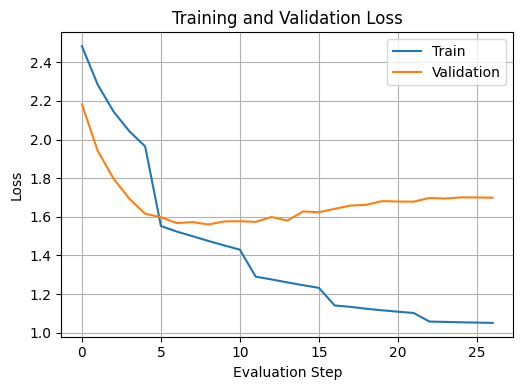

In [15]:
import matplotlib.pyplot as plt

# Plot training curves
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Evaluation Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

## 6. Evaluation 
<a id="6-evaluation"></a>

Let's evaluate our trained model and explore text generation. Note that we did not use test dataset in any part during training; not even to decide how good our model was. In general you need to be disciplined about 

In [16]:
# Final evaluation
final_test_loss = evaluate(model, test_loader, max_batches=100)
print(f"Final Test Loss: {final_test_loss:.4f}")

Final Test Loss: 1.7555


In [17]:
# Generate text with different prompts
prompts = [
    "ROMEO:",
    "To be or not to be",
    "The king",
    "Love is"
]

print("Text Generation Examples")
print("=" * 60)

for prompt in prompts:
    print(f"\nPrompt: '{prompt}'")
    print("-" * 40)
    generate_text(model, tokenizer, prompt, max_tokens=150, temperature=0.8)
    print()

Text Generation Examples

Prompt: 'ROMEO:'
----------------------------------------
ROMEO:
No, sir, your own will be so bedience?
Wherefore, we are less the people, to help,
In my might worthy man, you are with such a platers to dear: the V


Prompt: 'To be or not to be'
----------------------------------------
To be or not to bear a ground, I; he will not to the ghold
As I have seak of the consul.

COMINIUS:
Then will I do beseech you in joy at heart,
At part that you are tou


Prompt: 'The king'
----------------------------------------
The king of remains
To be of my virtue. Not this first here with the goods
For that you do see thee used in state, whose gods forbid
The good one fand of dear


Prompt: 'Love is'
----------------------------------------
Love is the which the could so,
To help art of my further.

First Citizen:
Because you, Coriolanus! You were be too the multitude of
our tribunes: thus accus



In [18]:
# Demonstrate effect of temperature
print("Effect of Temperature on Generation")
print("=" * 60)
print("\nLower temperature = more deterministic, higher = more random\n")

prompt = "HAMLET:"

for temp in [0.5, 0.8, 1.0, 1.5]:
    print(f"\nTemperature = {temp}:")
    print("-" * 40)
    generate_text(model, tokenizer, prompt, max_tokens=100, temperature=temp)

Effect of Temperature on Generation

Lower temperature = more deterministic, higher = more random


Temperature = 0.5:
----------------------------------------
HAMLET:
Being 'tis to the gods!

MARCIUS:
Come, come.

COMINIUS:
The people are to disease the field
To mak

Temperature = 0.8:
----------------------------------------
HAMLET:
Go on;
If you'll be the patricians, as power they to disease,
That is the power of pride.

CORIOLAN

Temperature = 1.0:
----------------------------------------
HAMLET:
On by Jupiter, I am go word!

SICINIUS:
Marcius.

COMINIUS:
I that will falsh, and made my love.

M

Temperature = 1.5:
----------------------------------------
HAMLET:Coriolanus. Ay, alm,
Half he general man! egome,--

This with engeral hears I that I am may city;
Fr


## 7. Chat Interface 
<a id="7-chat-interface"></a>

Now let's create a simple chat interface. Note that our model is trained on Shakespeare, so it will respond in that style rather than as a modern chatbot.

To make this work as a "chat", we'll format the conversation with speaker labels.

In [19]:
class ChatInterface:
    """A simple chat interface for the language model.
    
    This formats conversations as a dialogue between USER and ASSISTANT,
    then uses the language model to generate responses.
    """
    
    def __init__(self, model, tokenizer, device, 
                 max_response_tokens=200, temperature=0.8, 
                 user_name="COMINIUS", assistant_name="HAMLET"):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.max_response_tokens = max_response_tokens
        self.temperature = temperature
        self.user_name = user_name
        self.assistant_name = assistant_name
        
        # Conversation history
        self.history = []
        
    def reset(self):
        """Clear conversation history."""
        self.history = []
        print("Conversation reset.")
    
    def format_conversation(self):
        """Format conversation history as a string."""
        formatted = ""
        for role, message in self.history:
            formatted += f"{role}:\n{message}\n\n"
        return formatted
    
    def chat(self, user_input):
        """Send a message and get a response.
        
        Args:
            user_input: The user's message
            
        Returns:
            The model's response
        """
        # Add user message to history
        self.history.append((self.user_name, user_input))
        
        # Create prompt with conversation history
        prompt = self.format_conversation()
        prompt += f"{self.assistant_name}:\n"
        
        # Truncate if too long (keep recent context)
        max_prompt_len = self.model.block_size
        if len(prompt) > max_prompt_len:
            prompt = prompt[-max_prompt_len:]
        
        # Encode prompt
        tokens = self.tokenizer.encode(prompt)
        x = torch.tensor([tokens], dtype=torch.long, device=self.device)
        
        # Generate response
        self.model.eval()
        output = self.model.generate(
            x, 
            max_new_tokens=self.max_response_tokens,
            temperature=self.temperature,
            top_k=40
        )
        
        # Decode full output
        full_text = self.tokenizer.decode(output[0].tolist())
        
        # Extract just the response (after the last ASSISTANT:)
        response = full_text[len(prompt):]
        
        # Stop at next speaker label or double newline
        for stop_token in [f"\n{self.user_name}:", f"\n{self.assistant_name}:", "\n\n\n"]:
            if stop_token in response:
                response = response[:response.index(stop_token)]
        
        response = response.strip()
        
        # Add response to history
        self.history.append((self.assistant_name, response))
        
        return response
    
    def interactive(self):
        """Run an interactive chat session."""
        print("="*60)
        print("Chat with the Shakespeare-trained Language Model")
        print("="*60)
        print("Commands:")
        print("  'quit' or 'exit' - End the conversation")
        print("  'reset' - Clear conversation history")
        print("  'history' - Show conversation history")
        print("="*60)
        print()
        
        while True:
            try:
                user_input = input(f"{self.user_name}: ").strip()
            except EOFError:
                print("\nGoodbye!")
                break
            
            if not user_input:
                continue
            
            if user_input.lower() in ['quit', 'exit']:
                print("Goodbye!")
                break
            
            if user_input.lower() == 'reset':
                self.reset()
                continue
            
            if user_input.lower() == 'history':
                print("\n--- Conversation History ---")
                print(self.format_conversation())
                print("--- End History ---\n")
                continue
            
            response = self.chat(user_input)
            print(f"{self.assistant_name}: {response}")
            print()

In [20]:
# Create chat interface
chat = ChatInterface(
    model=model,
    tokenizer=tokenizer,
    device=DEVICE,
    max_response_tokens=150,
    temperature=0.8
)

# Demo conversation
print("Demo Conversation:")
print("="*60)

demo_messages = [
    "What is love?",
    "Tell me about the king.",
    "How should I live my life?"
]


for msg in demo_messages:
    print(f"\nCOMINIUS: {msg}")
    response = chat.chat(msg)
    print(f"HAMLET: {response}")

Demo Conversation:

COMINIUS: What is love?
HAMLET: Nay the stride you in 's heart.

SICINIUS:
Was worthy discovedin, how their motiver.

CORIOLANUS:
And sword,
What makes me chose that hath bath
By the

COMINIUS: Tell me about the king.
HAMLET: Worthy man!
As I mountainous stand upon's to the market-place;
If his in were a worthy saay as as head the people, then;
If any four can him that he s

COMINIUS: How should I live my life?
HAMLET: O, he's a consul?

First Senator:
Not obth I shall sure speak.

Second Citizen:
If 'twere a word; if and come will on him,
Being he not have been my s


In [21]:
# Run interactive chat (uncomment to use)
# Note: This will only work in a Jupyter environment with input support

chat.reset()
# chat.interactive()  # Uncomment this line to start interactive chat

Conversation reset.
Chat with the Shakespeare-trained Language Model
Commands:
  'quit' or 'exit' - End the conversation
  'reset' - Clear conversation history
  'history' - Show conversation history



COMINIUS:  hello how do you do


HAMLET: O, they fed ones i' the violent have all'd left,
And from all the heart themselves, who
nothing, and but his man eck, no, no, for I think,
The shall k



COMINIUS:  I shall think you would not be that rude


HAMLET: They are the gods amb-place for his world: if any thought
The corn on peace of him.

SICINIUS:
I am gladed,
He did not his present. Come, come, you ar



COMINIUS:  quit


Goodbye!


## Summary

In this notebook, we built a complete language model from scratch:

### What We Learned

1. **Dataset**: Character-level tokenization converts text to integers. Training examples are (input, target) pairs where target is shifted by one position.

2. **Model**: A Transformer-based architecture

    We will learn more  on this later in the course. For the curious

4. **Loss**: Cross-entropy loss measures how well we predict the next token. 

5. **Training**: Standard gradient descent with AdamW optimizer, gradient clipping, and learning rate scheduling.

6. **Generation**: Autoregressive sampling - predict one token at a time, append to context, repeat.

7. **Chat Interface**: Format conversations with speaker labels and generate responses.

### Key Takeaways

- Language models learn to predict the next token given context
- Training requires lots of data and compute (our small model is just a demonstration)
- Real LLMs (GPT-4, Claude, etc.) use the same principles but are much larger and trained on much more data

### Further Reading

- [Attention Is All You Need](https://arxiv.org/abs/1706.03762) - The original Transformer paper
- [nanoGPT](https://github.com/karpathy/nanoGPT) - Andrej Karpathy's minimal GPT implementation
- [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/) - Visual explanation of Transformers

## Exercises

Try these exercises to deepen your understanding:

1. **Different Data**: Download a different text corpus (e.g., Wikipedia, novels, code) and train on it. You can get datasets from the [torchtext module here](https://docs.pytorch.org/text/stable/datasets.html); pick the ones under the "unsupervised Learning category.".

3. **Different Model**: Try a different model like MLP/LSTM on this data.